In [1]:
%matplotlib inline
%run ../../import_envs.py
%run ../apg_hyperparams.py

CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

probtorch: 0.0+5a2c637 torch: 1.3.0
inference method:apg, apg sweeps:9, epochs:30, sample size:10, batch size:20, learning rate:0.0005


In [2]:
# load test data
test_sets = ['pts_20', 'pts_40', 'pts_60', 'pts_80', 'pts_100']
DATAs = []
for s in test_sets:
    data = torch.from_numpy(np.load(DATA_DIR + 'gmm/test/' + s + '/' + 'ob.npy')).float() ## load testing datasets
    DATAs.append(data)
## load the weights
from apg_modeling import init_model
model = init_model(model_params=model_params, 
                    CUDA=CUDA, 
                    DEVICE=DEVICE, 
                    LOAD_VERSION=LOAD_VERSION,
                    LR=None)

<Figure size 432x288 with 0 Axes>

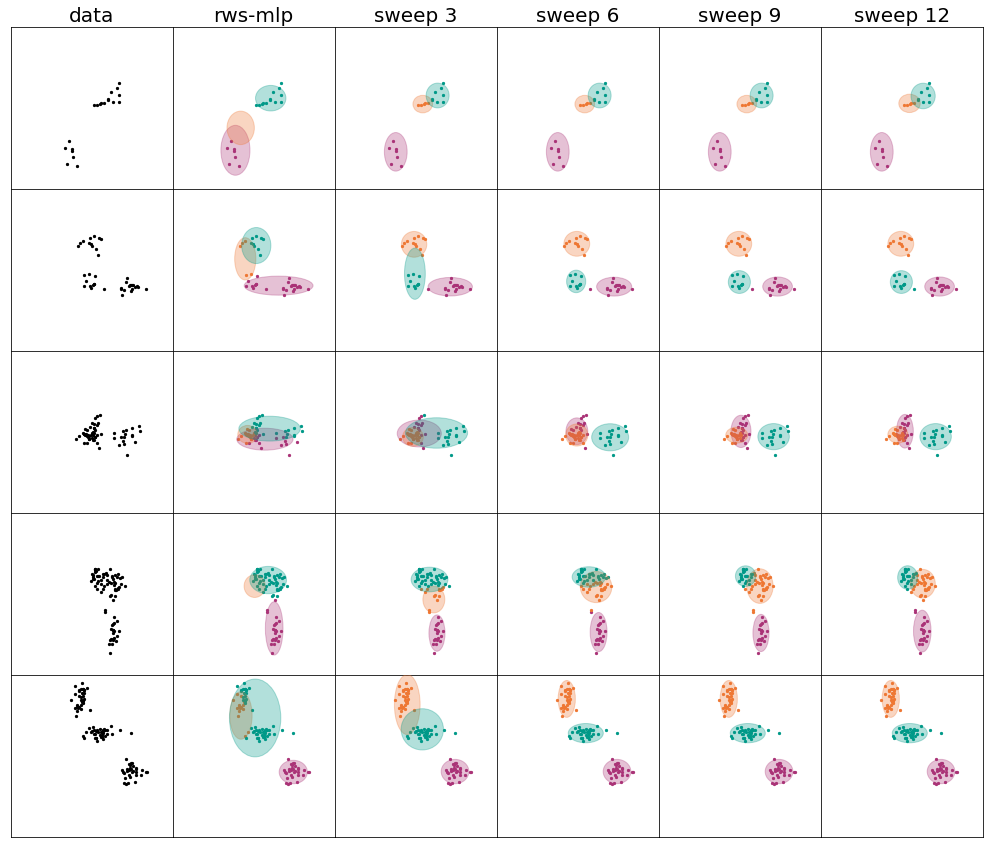

In [5]:
## visualize samples
%run ../apg_testing.py
from viz import viz_samples

APG_SWEEPS_TEST = 12
DATA_PTR = 7
SAVE_NAME = 'samples-%d' % DATA_PTR

datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)

metrics = test_single(model=model, 
                      apg_sweeps=APG_SWEEPS_TEST, 
                      datas=datas, 
                      sample_size=1, 
                      CUDA=CUDA, 
                      DEVICE=DEVICE)

viz_samples(datas=datas,
            metrics=metrics,
            apg_sweeps=APG_SWEEPS_TEST,
            K=K, 
            viz_interval=3, 
            figure_size=15, 
            title_fontsize=20, 
            marker_size=5.0, 
            opacity=0.3, 
            bound=15, 
            colors=['#AA3377', '#EE7733', '#009988', '#0077BB', '#BBBBBB', '#EE3377', '#DDCC77'],
            save_name=None)

In [ ]:
## plot the ess and log joint
APG_SWEEP_TEST = 30
SAMPLE_SIZE_TEST = 100
metrics = test_single(model=model, 
                      resample=resample,
                      apg_objective=apg_objective, 
                      apg_sweeps=APG_SWEEP_TEST, 
                      datas=datas, 
                      sample_size=SAMPLE_SIZE_TEST, 
                      CUDA=CUDA, 
                      DEVICE=DEVICE)

# viz_metrics(metrics, figure_size, title_fontsize, save_name=)